In [ ]:
# !pip install geoscan
# !pip install pyspark
# !pip install geopy
# !pip install shapely
# !pip install folium
# !pip install --upgrade setuptools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle, geodesic
from shapely.geometry import MultiPoint
import folium
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lit
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, ArrayType, DoubleType

In [2]:
# Suppress scientific notations for large float values
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

### Import SWIRTS Data

In [ ]:
# ca_collision_selected = pd.read_csv('ca_collision_new.csv', header='infer')
sd_collision_selected = pd.read_csv(
    'Collisions_SWITRS.csv', header='infer', low_memory=False)

### Filter the data to show only accidents for past 5 years

In [4]:
# Only selecting Latitude and Longitude for the DBSCAN algorithm
sd_collision_selected_x = sd_collision_selected[[
    "ACCIDENT YEAR", "LATITUDE sandag", "LONGITUDE sandag"]].loc[sd_collision_selected["LONGITUDE sandag"] > -117.75, :].loc[sd_collision_selected["ACCIDENT YEAR"] > 2017, :][["LATITUDE sandag", "LONGITUDE sandag"]]
sd_collision_selected_x = sd_collision_selected_x.dropna()
sd_collision_selected_x

,LATITUDE sandag,LONGITUDE sandag
106008,33.0474,-117.2596
106017,32.5838,-117.0945
106018,32.7777,-117.1377
106034,32.7948,-117.1937
106039,32.7462,-117.0428
...,...,...
227490,32.6943,-117.1748
227587,32.6954,-117.1854
227618,32.6972,-117.1731
227620,32.6801,-117.1760


In [5]:
# Convert the df to np array for DBSCAN to process
coords = sd_collision_selected_x.values

In [6]:
#  DBSCAN alorithm configuration
kms_per_radian = 6371.0088
epsilon = 2 / kms_per_radian

# DBSCAN fit
db = DBSCAN(eps=epsilon, min_samples=15, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# db variable contains all the model details including lables of the clusters created.
cluster_labels = db.labels_

# Printing cluster numbers
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 11


### Showing the outliers, which are indexed at "-1"

In [7]:
coor_x = (coords[cluster_labels == -1])
# len(coor_x)
coor_x

array([[  32.563     , -117.54      ],
       [  32.551     , -117.652     ],
       [  32.61787796, -116.1899567 ],
       ...,
       [  33.01484   , -116.44448   ],
       [  33.20998   , -116.34071   ],
       [  33.13762   , -116.13281   ]])

### Displaying all the clusters

In [8]:
clusters

0     [[33.04737803, -117.25960413], [32.58375778, -...
1     [[33.23231, -116.40136], [33.21114, -116.44382...
2     [[33.13529, -116.35525], [33.13477, -116.38249...
3     [[33.40979, -116.81728], [33.35794, -116.74401...
4     [[33.09853, -116.47075], [33.10132, -116.48311...
5     [[33.24475, -116.68162], [33.19962, -116.71021...
6     [[33.31667, -116.69348], [33.31887, -116.69799...
7     [[33.28521, -116.66491], [33.28585, -116.61683...
8     [[33.25345, -116.79235], [33.22482, -116.75401...
9     [[32.77535, -116.66838], [32.75364, -116.67369...
10                                                   []
dtype: object

### Get centermost point for each cluster

In [9]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters[:-1].map(get_centermost_point)

### Extract Latitudes and Longitudes for each point

In [10]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

### Remove the blank cluster

In [11]:
cluster_x = clusters[:-1]
(cluster_x)

0    [[33.04737803, -117.25960413], [32.58375778, -...
1    [[33.23231, -116.40136], [33.21114, -116.44382...
2    [[33.13529, -116.35525], [33.13477, -116.38249...
3    [[33.40979, -116.81728], [33.35794, -116.74401...
4    [[33.09853, -116.47075], [33.10132, -116.48311...
5    [[33.24475, -116.68162], [33.19962, -116.71021...
6    [[33.31667, -116.69348], [33.31887, -116.69799...
7    [[33.28521, -116.66491], [33.28585, -116.61683...
8    [[33.25345, -116.79235], [33.22482, -116.75401...
9    [[32.77535, -116.66838], [32.75364, -116.67369...
dtype: object

### Plotting the clusters

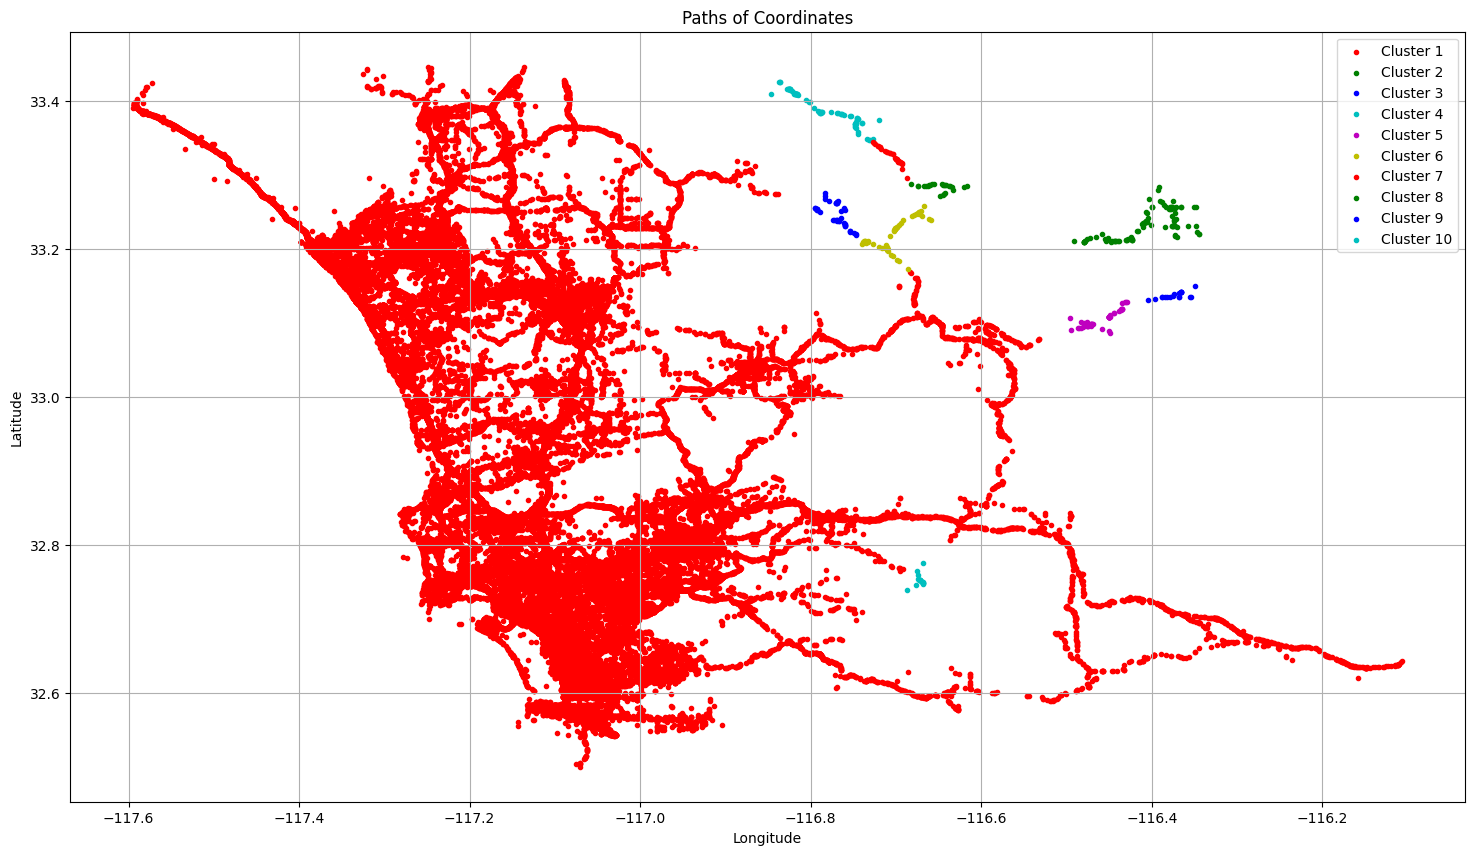

In [16]:
# Set up the plot
plt.figure(figsize=(18, 10))

# List of colors for different arrays
colors = ['r', 'g', 'b', 'c', 'm', 'y']

for i, coord_set in cluster_x.items():  # Use .items() to iterate over the Series # Ensure the list is not empty
    lats, lons = zip(*coord_set)  # Separate latitudes and longitudes
    # plt.plot(lons, lats, marker='o', label=f'Path {i+1}', color=colors[i % len(colors)])
    plt.scatter(lons, lats, label=f'Cluster {
                i+1}', color=colors[i % len(colors)], marker='.')


# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Paths of Coordinates')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Cluster Distance Calculation

In [ ]:
def haversine(coord1, coord2):
    # Radius of Earth in miles
    R = 3958.8

    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in miles
    return R * c

### Flatten the coordinates to calculate the final dataframe with cluster participation

In [14]:
# Flattening the Series using a lambda function
all_coords = pd.Series(cluster_x.map(lambda x: list(
    chain(*[x])) if isinstance(x, list) else x).explode().tolist())

lats, lons = zip(*all_coords)

# Result
print(all_coords)
all_coords.to_csv("flat_coords.csv", index=False)

0         [33.04737803, -117.25960413]
1         [32.58375778, -117.09449274]
2         [32.77774757, -117.13766786]
3         [32.79478651, -117.19373449]
4         [32.74623954, -117.04282169]
                      ...             
109510          [32.74895, -116.66817]
109511          [32.75248, -116.67204]
109512          [32.73963, -116.68715]
109513          [32.75248, -116.67216]
109514           [32.74931, -116.6684]
Length: 109515, dtype: object


### This function identifies if the point is part of cluster
### We consider the cluster to be part of the cluster if it is at least 0.5 miles from any other cluster point

In [19]:
from scipy.spatial.distance import cdist

# New point to analyze
new_point = np.array([33.4, -117.6])

# Compute distances to all points in the dataset
distances = np.array([haversine(point, new_point)
                     for point in all_coords])

# print(distances)

# Check if the point is within eps distance of any cluster
eps = db.eps  # Use the same eps value as the trained DBSCAN
min_samples = db.min_samples  # Use the same min_samples value

# Count the number of neighbors within eps distance
neighbors_within_eps = sum(distances <= 0.5)

if neighbors_within_eps >= min_samples:
    print("The new point is part of a cluster.")
else:
    print("The new point is NOT part of any cluster.")

The new point is NOT part of any cluster.


### Using DBSCAN clusters to identify if the point is potential hotspot

In [32]:
sd_collision = pd.read_csv(
    'sd_collision.csv', header='infer', engine='pyarrow')


In [33]:
sd_collision_selected = sd_collision[["Start_Lat", "Start_Lng", "Weather_Timestamp", "Temperature_F", "Wind_Chill_F", "Humidity_pct", "Pressure_in", "Visibility_mi", "Wind_Direction", "Wind_Speed_mph", "Precipitation_in", "Weather_Condition",
                                      "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset"]]

# sd_collision_selected = sd_collision[["Start_Lat", "Start_Lng"]]

In [37]:
ditinct_Wind_Direction = sd_collision_selected['Wind_Direction'].unique()
print((ditinct_Wind_Direction))

ditinct_Weather_Condition = sd_collision_selected['Weather_Condition'].unique()
print((ditinct_Weather_Condition))

ditinct_Sunrise_Sunset = sd_collision_selected['Sunrise_Sunset'].unique()
print((ditinct_Sunrise_Sunset))

['WSW' 'SW' 'West' 'SSW' 'WNW' 'South' 'Unknown' 'NW' 'Calm' 'NNW' 'SE'
 'NNE' 'North' 'SSE' 'NE' 'East' 'ENE' 'ESE']
['Partly Cloudy' 'Scattered Clouds' 'Mostly Cloudy' 'Clear' 'Overcast'
 'Unknown' 'Mist' 'Haze' 'Volcanic Ash' 'Fog' 'Drizzle' 'Light Rain'
 'Rain' 'Heavy Rain' 'Light Drizzle' 'Thunderstorms and Rain' 'Hail'
 'Light Thunderstorms and Rain' 'Fair' 'Cloudy' 'Mostly Cloudy / Windy'
 'Fair / Windy' 'Heavy Rain / Windy' 'Light Rain / Windy' 'T-Storm'
 'Thunder' 'Light Snow' 'Thunder in the Vicinity' 'N/A Precipitation'
 'Rain / Windy' 'Cloudy / Windy' 'Partly Cloudy / Windy' 'Shallow Fog'
 'Smoke' 'Patches of Fog' 'Blowing Dust' 'Light Rain with Thunder'
 'Heavy T-Storm' 'Heavy Thunderstorms and Rain' 'Heavy Snow']
['Day' 'Night' 'Unknown']


In [36]:
# Replace specific values in a column
sd_collision_selected.loc[:, 'Wind_Direction'] = sd_collision_selected['Wind_Direction'].replace({
    'W': 'West',
    'S': 'South',
    'N': 'North',
    'E': 'East',
    'CALM': 'Calm',
    'VAR': 'Unknown',
    'S': 'South',
    'Variable': 'Unknown'
})

In [35]:
# Replace NaNs with column mean for numerical data
sd_collision_selected.loc[:, 'Wind_Chill_F'] = sd_collision_selected['Wind_Chill_F'].fillna(
    sd_collision_selected['Wind_Chill_F'].mean())
sd_collision_selected.loc[:, 'Temperature_F'] = sd_collision_selected['Temperature_F'].fillna(
    sd_collision_selected['Temperature_F'].mean())
sd_collision_selected.loc[:, 'Humidity_pct'] = sd_collision_selected['Humidity_pct'].fillna(
    sd_collision_selected['Humidity_pct'].mean())
sd_collision_selected.loc[:, 'Pressure_in'] = sd_collision_selected['Pressure_in'].fillna(
    sd_collision_selected['Pressure_in'].mean())
sd_collision_selected.loc[:, 'Visibility_mi'] = sd_collision_selected['Visibility_mi'].fillna(
    sd_collision_selected['Visibility_mi'].mean())
sd_collision_selected.loc[:, 'Wind_Speed_mph'] = sd_collision_selected['Wind_Speed_mph'].fillna(
    sd_collision_selected['Wind_Speed_mph'].mean())
sd_collision_selected.loc[:, 'Precipitation_in'] = sd_collision_selected['Precipitation_in'].fillna(
    sd_collision_selected['Precipitation_in'].mean())

# Replace NaNs with a placeholder for categorical data
sd_collision_selected.loc[:, 'Wind_Direction'] = sd_collision_selected['Wind_Direction'].fillna(
    'Unknown')
sd_collision_selected.loc[:, 'Weather_Condition'] = sd_collision_selected['Weather_Condition'].fillna(
    'Unknown')
sd_collision_selected.loc[:, 'Sunrise_Sunset'] = sd_collision_selected['Sunrise_Sunset'].fillna(
    'Unknown')

In [ ]:
# Automatically identify boolean columns
boolean_columns = sd_collision_selected.select_dtypes(include='bool').columns

# Convert all boolean columns to 0/1 and change the datatype to integer
for col in boolean_columns:
    # First, ensure that NaNs are replaced with False (or True, depending on your case)
    sd_collision_selected.loc[:, col] = sd_collision_selected[col].fillna(
        False).astype(int)

### compute expensive approach using row by row compute

In [ ]:
# # Function to compute distances and check cluster membership

# def check_cluster_membership(row, all_coords, eps, min_samples):
#     # Convert row to new_point
#     new_point = np.array([row["Start_Lat"], row["Start_Lng"]])

#     # Compute distances to all points in the dataset
#     distances = np.array([haversine(point, new_point) for point in all_coords])

#     # Count neighbors within eps distance
#     neighbors_within_eps = sum(distances <= eps)

#     # Determine cluster membership
#     return 1 if neighbors_within_eps >= min_samples else 0


# # DBSCAN parameters
# eps = db.eps  # Replace with your DBSCAN epsilon
# min_samples = db.min_samples  # Replace with your DBSCAN minimum samples

# # Apply the function to each row of the DataFrame
# df["Cluster_Membership"] = sd_collision_selected.apply(
#     check_cluster_membership,
#     axis=1,
#     args=(all_coords, eps, min_samples)
# )

# print(sd_collision_selected)

### Using Spark to compute the cluster participation for each point

In [27]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Cluster Membership") \
    .getOrCreate()

sd_collision_selected = spark.createDataFrame(sd_collision_selected)

# DBSCAN parameters
eps = db.eps  # Replace with your DBSCAN epsilon
min_samples = db.min_samples  # Replace with your DBSCAN minimum samples

24/11/24 20:52:46 WARN Utils: Your hostname, MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.12 instead (on interface en0)
24/11/24 20:52:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 20:52:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [28]:
# Define haversine function for PySpark
def haversine(lat1, lon1, lat2, lon2):
    """
    Compute haversine distance between two points in miles.
    """
    R = 3958.8  # Radius of Earth in miles

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * \
        np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

# Create a UDF for haversine distance computation


def compute_membership(start_lat, start_lng, eps, min_samples, all_coords):
    """
    Determines if a point belongs to a cluster based on DBSCAN-like parameters.
    """
    distances = [haversine(start_lat, start_lng, coord[0], coord[1])
                 for coord in all_coords]
    neighbors_within_eps = sum(d <= 0.5 for d in distances)

    return 1 if neighbors_within_eps >= min_samples else 0

In [29]:
# Define and register the UDF correctly
membership_udf = F.udf(
    lambda lat, lng: compute_membership(
        lat, lng, eps, min_samples, all_coords),
    IntegerType()
)

In [30]:
# Add cluster membership column
sd_collision_selected = sd_collision_selected.withColumn("Cluster_Membership", membership_udf(F.col("Start_Lat"), F.col("Start_Lng")))

# Show results
# sd_collision_selected.filter(sd_collision_selected.Cluster_Membership == 1).show()
# sd_collision_selected.show()

# sd_collision_selected.persist()
sd_collision_selected.show()

24/11/24 20:53:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/24 20:53:57 WARN TaskSetManager: Stage 0 contains a task of very large size (1514 KiB). The maximum recommended task size is 1000 KiB.
Exception ignored in: <_io.BufferedWriter name=5>                   (0 + 1) / 1]
Traceback (most recent call last):
  File "/Users/shadowclone/Documents/coursework/BDA594/group Project/data_processing/.venv/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
BrokenPipeError: [Errno 32] Broken pipe


+------------------+-------------------+-------------------+-------------+-----------------+------------+-----------+-------------+--------------+--------------+--------------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+------------------+
|         Start_Lat|          Start_Lng|  Weather_Timestamp|Temperature_F|     Wind_Chill_F|Humidity_pct|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|    Precipitation_in|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Cluster_Membership|
+------------------+-------------------+-------------------+-------------+-----------------+------------+-----------+-------------+--------------+--------------+--------------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+--

### Based on the above dataframe we will be training the Random forest algorithm (One Time Operation done in Snowflake)

In [ ]:
# pre_rf_df_pd = sd_collision_selected.toPandas()

In [ ]:
# Save Result to csv
# sd_collision_selected.write.csv('/Users/shadowclone/Documents/coursework/BDA594/group Project/data_processing/pre_rf_data')

# Code end here ------------------------------------------- Ignore the rest of analysis work

In [ ]:
# Perform kernel density estimation for a heatmap
xy = np.vstack([lons, lats])
z = gaussian_kde(xy)(xy)

# Create a scatter plot with density as the colormap
plt.figure(figsize=(16, 12))
plt.scatter(lons, lats, c=z, s=16, cmap='viridis', edgecolor='k', alpha=0.5)
plt.colorbar(label='Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Heatmap of Points')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Flatten the coordinates into two lists: latitudes and longitudes
# Separate latitude and longitude for plotting
latitudes = coor_x[:, 0]
longitudes = coor_x[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=[14, 12])
rs_scatter = ax.scatter(longitudes, latitudes, c='red', marker='o', label='Accident outliers')
# df_scatter = ax.scatter(sd_collision_selected_x["LONGITUDE sandag"],
#                         sd_collision_selected_x["LATITUDE sandag"], c='k', alpha=0.9, s=1)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [ ]:
# clusters
cluster_df = clusters[:-1].to_frame(name="coords")
# cluster_df
cluster_array = cluster_df["coords"].to_numpy()
# print(c)

In [ ]:
cluster_data = []
for cluster_id, points in enumerate(cluster_array):
    points = np.array(points)
    center = points.mean(axis=0)
    density = len(points)  # Number of points in the cluster
    cluster_data.append({'cluster_id': cluster_id,
                        'center_lat': center[0], 'center_lng': center[1], 'density': density})

cluster_df = pd.DataFrame(cluster_data)
cluster_df

In [ ]:
accident_data = pd.DataFrame({
    'latitude': [33.170689, 32.765957, 33.211552, 33.171, 32.766, 32.80],
    'longitude': [-117.20784, -117.128, -116.738358, -117.208, -117.129, -117.00],
    'cluster_id': [0, 1, 2, 0, 1, 0]
})

In [ ]:
def compute_distance_to_cluster(point, cluster_centers):
    distances = [
        geodesic(point, center).miles for center in cluster_centers]
    return min(distances), distances.index(min(distances))

# Function to check if a point belongs to a cluster
def is_point_in_cluster(point, cluster_points, eps):
    distances = np.linalg.norm(
        cluster_points - point, axis=1)  # Compute distances
    return np.any(distances <= eps)  # Check if within epsilon radius

In [ ]:
cluster_centers = cluster_df[['center_lat', 'center_lng']].values

# Replace Euclidean distance calculation with the modified function
accident_data['distance_to_nearest_cluster'] = accident_data.apply(lambda row: compute_distance_to_cluster([row['latitude'], row['longitude']], cluster_centers)[0], axis=1)

In [ ]:
accident_data['distance_to_nearest_cluster'] = accident_data.apply(
    lambda row: compute_distance_to_cluster([row['latitude'], row['longitude']], cluster_centers)[0], axis=1
)
accident_data['density_of_nearest_cluster'] = accident_data['cluster_id'].map(
    cluster_df.set_index('cluster_id')['density']
)


In [ ]:
accident_data

In [ ]:
# Adding a binary target (e.g., high risk if density > 1)
accident_data['risk_label'] = (
    accident_data['distance_to_nearest_cluster'] < 0.5).astype(int)

In [ ]:
X = accident_data[['latitude', 'longitude',
                   'distance_to_nearest_cluster', 'density_of_nearest_cluster']]
y = accident_data['risk_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
new_point = pd.DataFrame({'latitude': [33.25], 'longitude': [-117.75]})
new_point['distance_to_nearest_cluster'], nearest_cluster_id = compute_distance_to_cluster(
    [new_point['latitude'].iloc[0], new_point['longitude'].iloc[0]],
    cluster_centers
)
new_point['density_of_nearest_cluster'] = cluster_df.loc[nearest_cluster_id, 'density']

new_point_features = new_point[['latitude', 'longitude',
                                'distance_to_nearest_cluster', 'density_of_nearest_cluster']]
risk_prediction = model.predict(new_point_features)
print(f"Predicted risk: {risk_prediction[0]}")